In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func, Column, Integer, String, Float, Date, MetaData, Table
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, declarative_base
import matplotlib.pyplot as plt

In [2]:


measurements_df = pd.read_csv('hawaii_measurements.csv')
stations_df = pd.read_csv('hawaii_stations.csv')

engine = create_engine("sqlite:///hawaii.db")


Base = declarative_base()

class Measurement(Base):
    __tablename__ = 'measurement'
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(Date)
    prcp = Column(Float)
    tobs = Column(Integer)

class Station(Base):
    __tablename__ = 'station'
    id = Column(Integer, primary_key=True)
    station = Column(String)
    name = Column(String)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)


Base.metadata.create_all(engine)


measurements_df.to_sql('measurement', engine, if_exists='replace', index=False)
stations_df.to_sql('station', engine, if_exists='replace', index=False)


session = Session(engine)

session.close()


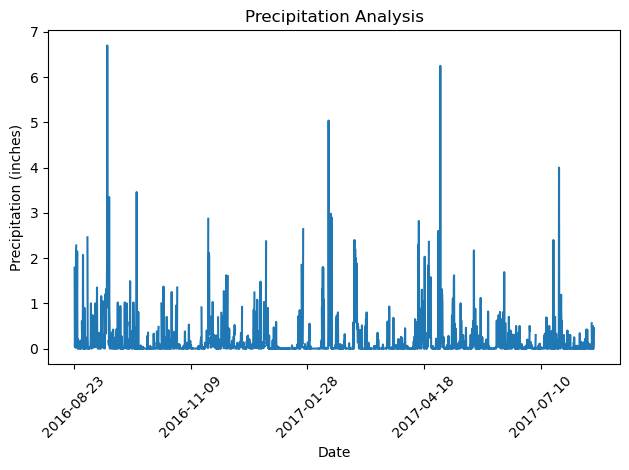

In [3]:


engine = create_engine("sqlite:///hawaii.db")

metadata = MetaData()
metadata.reflect(bind=engine)

Measurement = metadata.tables['measurement']

session = Session(engine)

latest_date = session.query(func.max(Measurement.c.date)).scalar()

latest_date = pd.to_datetime(latest_date)
one_year_ago = latest_date - pd.DateOffset(years=1)

latest_date_str = latest_date.strftime('%Y-%m-%d')
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

precipitation_data = session.query(Measurement.c.date, Measurement.c.prcp)\
    .filter(Measurement.c.date >= one_year_ago_str)\
    .filter(Measurement.c.date <= latest_date_str)\
    .all()


precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


precipitation_df = precipitation_df.sort_values(by='Date')


precipitation_df.set_index('Date', inplace=True)

precipitation_df.plot(y='Precipitation', title='Precipitation Analysis', legend=False)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


session.close()


In [4]:

summary_stats = precipitation_df.describe()

print(summary_stats)


       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [5]:

total_stations = session.query(func.count(Station.station)).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')

session.close()


The total number of stations in the dataset is: 9


In [10]:

most_active_stations = session.query(Measurement.c.station, func.count(Measurement.c.station))\
    .group_by(Measurement.c.station)\
    .order_by(func.count(Measurement.c.station).desc())\
    .all()


print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Observation Count: {count}")


most_active_station_id = most_active_stations[0][0]
print(f"The station with the greatest number of observations is: {most_active_station_id}")



Most Active Stations:
Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511
The station with the greatest number of observations is: USC00519281


In [11]:

temperatures = session.query(func.min(Measurement.c.tobs), func.max(Measurement.c.tobs), func.avg(Measurement.c.tobs))\
    .filter(Measurement.c.station == most_active_station_id)\
    .all()


min_temp, max_temp, avg_temp = temperatures[0]
print(f"Temperature Statistics for Station {most_active_station_id}:")
print(f"Minimum Temperature: {min_temp} F")
print(f"Maximum Temperature: {max_temp} F")
print(f"Average Temperature: {avg_temp} F")


Temperature Statistics for Station USC00519281:
Minimum Temperature: 54 F
Maximum Temperature: 85 F
Average Temperature: 71.66378066378067 F


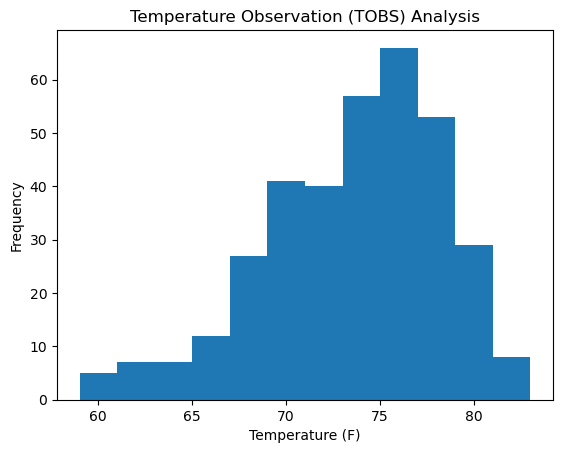

In [12]:

tobs_data = session.query(Measurement.c.date, Measurement.c.tobs)\
    .filter(Measurement.c.station == most_active_station_id)\
    .filter(Measurement.c.date >= one_year_ago_str)\
    .filter(Measurement.c.date <= latest_date_str)\
    .all()


tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])
tobs_df.plot.hist(bins=12, title='Temperature Observation (TOBS) Analysis', legend=False)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()
